In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#!pip install node2vec
#!pip install lightgbm

In [8]:
import numpy as np
import os
import csv
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import networkx as nx

from scipy import sparse

import lightgbm
from lightgbm import LGBMClassifier

import pickle 

import logging
logging.disable(logging.INFO)

# Read Data

In [44]:
dir_path = r'C:\Users\User\Desktop\MSc Courses\Challenge DS\data\\'
TRAIN_FILE = dir_path + "train.csv"
TEST_FILE = dir_path + "test.csv"
GRAPH_FILE = dir_path + "edgelist.txt"
domains_path = r'C:\Users\User\Desktop\MSc Courses\Challenge DS\data\data_science_challenge_2019\domains\\'

def get_hosts_and_target():
    train_hosts = list()
    y_train = list()
    with open(TRAIN_FILE, 'r') as f:
        for line in f:
            l = line.split(',')
            train_hosts.append(l[0])
            y_train.append(l[1][:-1])

    # Read test data
    test_hosts = list()
    with open(TEST_FILE, 'r') as f:
        for line in f:
            l = line.split(',')
            test_hosts.append(l[0])

    return train_hosts, test_hosts, y_train

def get_graph_edges(train_hosts, test_hosts):
    # Create a directed graph
    G = nx.read_edgelist(GRAPH_FILE, delimiter=' ', \
                         create_using=nx.DiGraph())

    print(G.number_of_nodes())
    print(G.number_of_edges())

    # Create the training matrix. Each row corresponds to a web host.
    # Use the following 3 features for each web host:
    # (1) out-degree of node
    # (2) in-degree of node
    # (3) average degree of neighborhood of node
    X_train_graph = np.zeros((len(train_hosts), 3))
    avg_neig_deg = nx.average_neighbor_degree(G, 
                                              nodes=train_hosts)
    for i in range(len(train_hosts)):
        X_train_graph[i,0] = G.in_degree(train_hosts[i])
        X_train_graph[i,1] = G.out_degree(train_hosts[i])
        X_train_graph[i,2] = avg_neig_deg[train_hosts[i]]

    # Create the test matrix. Use the same 3 features as above
    X_test_graph = np.zeros((len(test_hosts), 3))
    avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_hosts)
    for i in range(len(test_hosts)):
        X_test_graph[i,0] = G.in_degree(test_hosts[i])
        X_test_graph[i,1] = G.out_degree(test_hosts[i])
        X_test_graph[i,2] = avg_neig_deg[test_hosts[i]]

    print("Train matrix dimensionality: ", X_train_graph.shape)
    print("Test matrix dimensionality: ", X_test_graph.shape)
    
    return X_train_graph, X_test_graph, G

def get_text_tfidf(train_hosts, test_hosts):
    text = dict()
    filenames = os.listdir(domains_path)
    for filename in filenames:
        if filename[-4:] == '.zip':
            z = zipfile.ZipFile(domains_path + filename)
            contents = z.namelist()
            text[filename[:-4]] = ''
            for c in contents:
                f = z.open(c)
                data = f.read()
                text[filename[:-4]] += data.decode('utf16') #for windows: latin1
                f.close()

    train_data = list()
    for host in train_hosts:
        if host in text:
            train_data.append(text[host])
        else:
            train_data.append('')


    # Create the training matrix. Each row corresponds to a webpage and each column 
    # to a word present in at least 10 webpages 
    # and at most 50 webpages. The value of each entry in a row is equal to 
    # the frequency of that word in the corresponding
    # webpage       
    vec = TfidfVectorizer(decode_error='ignore', strip_accents='unicode', min_df=10, max_df=50)
    X_train_text = vec.fit_transform(train_data)

    # Read webpages of the test set
    test_data = list()
    for host in test_hosts:
        if host in text:
            print(host)
            test_data.append(text[host])
        else:
            test_data.append('')


    # Create the test matrix following the same approach as in the case of the training matrix
    X_test_text = vec.transform(test_data)

    print("Train matrix dimensionality: ", X_train_text.shape)
    print("Test matrix dimensionality: ", X_test_text.shape)

    return X_train_text, X_test_text, train_data, text

In [45]:
train_hosts, test_hosts, y_train = get_hosts_and_target()
X_train_graph, X_test_graph, G = get_graph_edges(train_hosts, test_hosts)
X_train_text, X_test_text, train_texts, text = get_text_tfidf(train_hosts, test_hosts)

X_train = sparse.hstack((X_train_text,X_train_graph))

X_test = sparse.hstack((X_test_text,X_test_graph))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(len(y_train)))
print('X_test shape: {}'.format(X_test.shape))

65208
1642073
Train matrix dimensionality:  (800, 3)
Test matrix dimensionality:  (200, 3)
buybuycity.gr
aromalefkadas.gr
bestseller.gr
corfuwall.gr
contra.gr
acsys1.gr
cookshop.gr
3ds.gr
cosmictelegram.gr
avmag.gr
astrologos.gr
cine.gr
colpogrosso.gr
alpinefitness.gr
bianchi.gr
aelole.gr
athlisis.gr
aquaexterior.gr
acstore.gr
costaslapavitsas.blogspot.gr
cris-dio1.blogspot.gr
ballmaske.gr
aetos-grevena.blogspot.gr
ballistic.gr
akous.gr
agrotikanew.blogspot.gr
bloko.gr
apostolos1963.blogspot.gr
bestpharmacy.gr
alexwebradiotv.blogspot.gr
agriniotimes.gr
Train matrix dimensionality:  (800, 7459)
Test matrix dimensionality:  (200, 7459)
X_train shape: (800, 7462)
y_train shape: 800
X_test shape: (200, 7462)


### Normalize Text

In [57]:
#!pip install greek-stemmer
import re
from nltk import word_tokenize
import spacy
from spacy.lang.el.examples import sentences 

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9f in position 49: character maps to <undefined>

#### Sample Text
 - Remove urls
 - Tokenize words
 - Lemmatize words

In [113]:
sample_text = text['bloko.gr']
sample_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', sample_text, flags=re.MULTILINE)
nlp = spacy.load('el_core_news_sm')
sample_text = nlp(sample_text)
sample_text_tokens = [token.lemma_ for token in sample_text if ('\n' not in token.lemma_) and (len(token.lemma_)>3)]

In [115]:
sample_text_tokens

['αλλάζω',
 'βαθμολόγιος',
 'σύστημα',
 'κρίσεο',
 'στην',
 'έρχομαι',
 'παράλληλη',
 'επετηρίδα',
 'αλλά',
 'κίνητρο',
 'αστυνομίος',
 'κρίσεις',
 'προαγωγέ',
 'σωματα',
 'ασφαλειας',
 'αργότερο',
 'μέχρι',
 'μέσα',
 'μαΐο',
 'αλλάξω',
 'σύστημα',
 'αξιολόγηση',
 'αξιωματικός',
 'αστυνομία',
 'καθώς',
 'ετήσιος',
 'κρίσεο',
 'πρόθεση',
 'αποτελώ',
 'γίνω',
 'αξιοκρατικό',
 'δίκαιο',
 'προσθήκη',
 'δικλείδα',
 'βαλβίδα',
 'ασφαλεία',
 'ακόμα',
 'τους',
 'βαθμοφόρου',
 'οδηγούνται',
 'προς',
 'έξοδο',
 'σύμφωνα',
 'ασφαλείς',
 'πληροφορία',
 'στελέχη',
 'αρχηγείο',
 'αλλά',
 'συνδικαλιστής',
 'ποαξιας',
 'μελετάται',
 'σχέδιο',
 'ριζικός',
 'αναδιάρθρωση',
 'αξιολόγηση',
 'πρώτη',
 'σκέψη',
 'αποτελώ',
 'αλλαγή',
 'συστήματο',
 'βαθμολόγηση',
 'αξιωματικός',
 'σήμερα',
 'γίνομαι',
 'μέτρο',
 'δεκαδικό',
 'σύστημα',
 'αρίθμηση',
 'αλλά',
 'μέχρι',
 'χωρίς',
 'δυνατότητα',
 'παράθεση',
 'δεκαδικός',
 'ψηφίο',
 'στους',
 'ακέραιους',
 'αριθμού',
 'αποτέλεσμα',
 'αυτού',
 'συστήματο',
 'είν

In [146]:
def tokens_to_graph(text_tokens):
#     G = nx.DiGraph()
    G = nx.Graph()
    for i in range(0, len(text_tokens) -1):
        G.add_edge(text_tokens[i], text_tokens[i+1])
        
    return G

In [147]:
import networkx as nx
G = tokens_to_graph(sample_text_tokens)

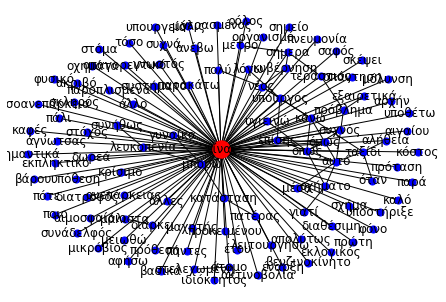

In [148]:
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline  

# Create a BA model graph
n = 1000
m = 2
#G = nx.generators.barabasi_albert_graph(n, m)
# find node with largest degree
node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
# Create ego graph of main hub
hub_ego = nx.ego_graph(G, largest_hub)
# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=True)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='r')
plt.show()

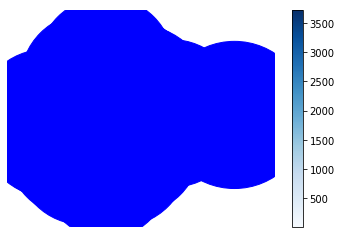

In [125]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

#G = nx.generators.directed.random_k_out_graph(10, 3, 0.5)
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [131]:
from matplotlib import pylab

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph.pdf")

In [153]:
# !pip install grakel-dev
# from grakel.kernels import WeisfeilerLehman, VertexHistogram
# from grakel import Graph

from networkx import core_number
a = core_number(G)

{'αλλάζω': 1,
 'βαθμολόγιος': 1,
 'σύστημα': 3,
 'κρίσεο': 3,
 'στην': 4,
 'έρχομαι': 2,
 'παράλληλη': 2,
 'επετηρίδα': 3,
 'αλλά': 3,
 'κίνητρο': 2,
 'αστυνομίος': 2,
 'κρίσεις': 2,
 'προαγωγέ': 2,
 'σωματα': 2,
 'ασφαλειας': 2,
 'αργότερο': 2,
 'μέχρι': 3,
 'μέσα': 4,
 'μαΐο': 2,
 'αλλάξω': 2,
 'αξιολόγηση': 3,
 'αξιωματικός': 3,
 'αστυνομία': 3,
 'καθώς': 3,
 'ετήσιος': 2,
 'πρόθεση': 3,
 'αποτελώ': 3,
 'γίνω': 3,
 'αξιοκρατικό': 2,
 'δίκαιο': 2,
 'προσθήκη': 2,
 'δικλείδα': 2,
 'βαλβίδα': 2,
 'ασφαλεία': 2,
 'ακόμα': 3,
 'τους': 4,
 'βαθμοφόρου': 2,
 'οδηγούνται': 2,
 'προς': 3,
 'έξοδο': 3,
 'σύμφωνα': 3,
 'ασφαλείς': 2,
 'πληροφορία': 3,
 'στελέχη': 3,
 'αρχηγείο': 3,
 'συνδικαλιστής': 2,
 'ποαξιας': 2,
 'μελετάται': 2,
 'σχέδιο': 2,
 'ριζικός': 2,
 'αναδιάρθρωση': 2,
 'πρώτη': 3,
 'σκέψη': 2,
 'αλλαγή': 2,
 'συστήματο': 2,
 'βαθμολόγηση': 2,
 'σήμερα': 3,
 'γίνομαι': 3,
 'μέτρο': 3,
 'δεκαδικό': 2,
 'αρίθμηση': 3,
 'χωρίς': 3,
 'δυνατότητα': 2,
 'παράθεση': 2,
 'δεκαδικός': 2,
 

### DATA augmentation

http://docs.cltk.org/en/latest/greek.html
<br>
https://github.com/eellak/gsoc2018-spacy#greek-language-models
<br>
https://github.com/eellak/gsoc2018-spacy
<br>
https://nlpbuddy.io/#
<br>



https://medium.com/@mgogoulos/%CE%B2%CF%81%CE%AF%CF%83%CE%BA%CE%BF%CE%BD%CF%84%CE%B1%CF%82-%CF%84%CE%B9%CF%82-%CF%80%CE%B9%CE%BF-%CE%BA%CE%BF%CE%BD%CF%84%CE%B9%CE%BD%CE%AD%CF%82-%CE%BB%CE%AD%CE%BE%CE%B5%CE%B9%CF%82-%CE%B3%CE%B9%CE%B1-%CF%84%CE%B7%CE%BD-%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%AE-%CE%B3%CE%BB%CF%8E%CF%83%CF%83%CE%B1-b7e563d1abaa


extract url text : https://github.com/buriy/python-readability
<br>
sentence splitter: https://github.com/berkmancenter/mediacloud-sentence-splitter

### Initial try, work with 1 doc.

In [ ]:
#!pip install sentence_splitter
#! pip install googletrans
from googletrans import Translator
from sentence_splitter import SentenceSplitter, split_text_into_sentences
import re
import string

a = text['0-18.gr']
a = a.replace('\n', '. ')

splitter = SentenceSplitter(language='el')
sent_text = splitter.split(text=a)

# Normalize text # TODO
# a = text['0-6.gr']
# a = re.sub(r'^https?:\/\/.*[\r\n]*', '', a, flags=re.MULTILINE)
# a = a.replace('\n', ' ')
# a = a.replace("  ", ' ').strip()
# a = a.translate(str.maketrans('', '', string.punctuation))

# Translate text
english_text = ''
translator = Translator()
for i in range(0, len(sent_text), 5):
    joine_sent = ''.join(sent_text[i:i+5])
    temp = translator.translate(joine_sent, src='greek', dest='english').text
    english_text += temp

In [ ]:
english_text

In [129]:
from googletrans import Translator
from sentence_splitter import SentenceSplitter, split_text_into_sentences
import re
import string
a = 'μοιραστείτε'
translator = Translator()
temp = translator.translate(a, src='greek', dest='english').text

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

# Study Graph and node2vec

sources: https://towardsdatascience.com/graph-embeddings-the-summary-cc6075aba007
<br>
https://github.com/tkipf/gae
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [26]:
#!python gae/setup.py install
#!python gae/gae/train.py
#import gae

Traceback (most recent call last):
  File "gae/gae/train.py", line 17, in <module>
    from gae.optimizer import OptimizerAE, OptimizerVAE
ModuleNotFoundError: No module named 'gae.optimizer'


In [28]:
i = 0
for edge in G.edges:
    print(edge)
    i+=1
    if i==10:
        break

('blog.com.gr', 'fmvoice.gr')
('blog.com.gr', 'papakishop.gr')
('blog.com.gr', 'rizospastis.gr')
('blog.com.gr', 'taxheaven.gr')
('blog.com.gr', 'karagilanis.gr')
('blog.com.gr', 'korinthiannews.gr')
('blog.com.gr', '902.gr')
('blog.com.gr', 'dscor.gr')
('blog.com.gr', 'diogenis-press.gr')
('blog.com.gr', 'parakato.gr')


In [25]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G, dimensions=20, walk_length=16, num_walks=100)

# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)

# save the model to disk
filename = 'node2vec_model_100.sav'
pickle.dump(model, open(filename, 'wb'))

C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Computing transition probabilities:   0%|          | 175/65208 [00:07<1:11:19, 15.20it/s]

KeyboardInterrupt: 

In [26]:
# # Generate walks
# node2vec = Node2Vec(G, dimensions=20, walk_length=150, num_walks=150)

# # Learn embeddings 
# model = node2vec.fit(window=100, min_count=1)

# # save the model to disk
# filename = 'node2vec_model_100.sav'
# pickle.dump(model, open(filename, 'wb'))

NameError: name 'model' is not defined

In [34]:
filename = 'node2vec_model_100.sav'
with open(filename, 'rb') as f:
    node2vec_model_100 = pickle.load(f)

EOFError: Ran out of input

In [30]:
for i in range(0, 10):
    print('{host} - {target}'.format(host=train_hosts[i], target=y_train[i]))

goalpost.gr - athlitismos
sentragoal.gr - athlitismos
orangespotters.blogspot.gr - pliroforiki-diadiktyo
xanthinea.gr - eidiseis-mme
alfahost.gr - pliroforiki-diadiktyo
tro-ma-ktiko.blogspot.gr - pliroforiki-diadiktyo
ti-einai.gr - pliroforiki-diadiktyo
perizitito.gr - katastimata-agores
bambam.gr - pliroforiki-diadiktyo
deal-deal.gr - katastimata-agores


In [31]:
for node, _ in node2vec_model.most_similar('sentragoal.gr'):
    if node in train_hosts:
        print('{host} - {target}'.format(host=node, target=y_train[train_hosts.index(node)]))
    elif node in test_hosts:
        print('{host} - In test'.format(host=node))
    else:
        print('{host} - Neither in test nor in train'.format(host=node))

C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


newsonly.gr - Neither in test nor in train
caranddriver.gr - eidiseis-mme
onliner.gr - Neither in test nor in train
life.gr - eidiseis-mme
sporty.gr - Neither in test nor in train
gazzetta.gr - athlitismos
petsonly.gr - Neither in test nor in train
cinemag.gr - diaskedasi-psyxagogia
aiolosvolley.blogspot.gr - Neither in test nor in train
sport24.gr - athlitismos


In [36]:
for node in G.neighbors('sentragoal.gr'):
    if node in train_hosts:
        print('{host} - {target}'.format(host=node, target=y_train[train_hosts.index(node)]))
    elif node in test_hosts:
        print('{host} - In test'.format(host=node))
    else:
        print('{host} - Neither in test nor in train'.format(host=node))

aoxalkisfc.gr - Neither in test nor in train
feed.gr - Neither in test nor in train
life.gr - eidiseis-mme
epo.gr - athlitismos
sport24.gr - athlitismos
hommemagazine.gr - Neither in test nor in train
esake.gr - Neither in test nor in train
ethnos.gr - eidiseis-mme
petsonly.gr - Neither in test nor in train
novasports.gr - Neither in test nor in train
novamedia.gr - Neither in test nor in train
thecookbook.gr - Neither in test nor in train
idanikospiti.gr - Neither in test nor in train
cinemag.gr - diaskedasi-psyxagogia
flynews.gr - Neither in test nor in train
gazzetta.gr - athlitismos
fenerbahceulkerbasket.blogspot.gr - Neither in test nor in train
tff.gr - diaskedasi-psyxagogia
newsonly.gr - Neither in test nor in train
protothema.gr - eidiseis-mme
imerisia.gr - Neither in test nor in train
e-go.gr - Neither in test nor in train
caranddriver.gr - eidiseis-mme
womenonly.gr - Neither in test nor in train
sportarena.gr - athlitismos
viva.gr - Neither in test nor in train
enwsi.gr - ath

### Notes:
* It seems that not all nodes in graph exist in either train or test.
* Similarity seems to work but not 100% from neighbors we get that a sports page can be connected to news and that same we see in similarity

In [55]:
similars = {}
for train_node in train_hosts:
    for node, _ in node2vec_model.most_similar(train_node):
        try:
            if node in train_hosts:
                similars[train_node].extend([y_train[train_hosts.index(node)]])
        except:
            if node in train_hosts:
                similars[train_node] = [y_train[train_hosts.index(node)]]
        '''
        try:
            if node in train_hosts:
                similars[train_node] = similars[train_node].extend({node:y_train[train_hosts.index(node)]})
        except:
            if node in train_hosts:
                similars[train_node] = [{node:y_train[train_hosts.index(node)]}]
        '''
# Check similar categories
for key, values in similars.items():
    print('{}-{}: {}'.format(y_train[train_hosts.index(key)], key, values))

/Users/georgiasarri/Workspace/Environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


athlitismos-goalpost.gr: ['athlitismos']
athlitismos-sentragoal.gr: ['eidiseis-mme', 'athlitismos', 'diaskedasi-psyxagogia']
pliroforiki-diadiktyo-tro-ma-ktiko.blogspot.gr: ['pliroforiki-diadiktyo', 'eidiseis-mme']
pliroforiki-diadiktyo-ti-einai.gr: ['katastimata-agores']
katastimata-agores-deal-deal.gr: ['diaskedasi-psyxagogia']
eidiseis-mme-theinsider.gr: ['pliroforiki-diadiktyo']
eidiseis-mme-voreini.gr: ['eidiseis-mme']
athlitismos-overlap.gr: ['athlitismos']
athlitismos-ioniansports.gr: ['athlitismos']
pliroforiki-diadiktyo-sibilla-gr-sibilla.blogspot.gr: ['pliroforiki-diadiktyo', 'eidiseis-mme', 'pliroforiki-diadiktyo']
eidiseis-mme-allnewz.gr: ['eidiseis-mme']
eidiseis-mme-prevezatoday.gr: ['pliroforiki-diadiktyo']
athlitismos-prismanews.gr: ['eidiseis-mme', 'eidiseis-mme']
eidiseis-mme-bankwars.gr: ['eidiseis-mme', 'eidiseis-mme', 'pliroforiki-diadiktyo', 'pliroforiki-diadiktyo']
eidiseis-mme-liberal.gr: ['eidiseis-mme', 'eidiseis-mme', 'eidiseis-mme']
katastimata-agores-homete

# Models

### Simple MLP on node embeddings

In [43]:
num_train_nodes = len(train_hosts)
embed_size = 20

In [46]:
#prepare embedding matrix
embedding_matrix = np.zeros((num_train_nodes, embed_size))
for index, node in enumerate(train_hosts):
    embedding_vector = node2vec_model[node]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector

C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [78]:
from sklearn import preprocessing
from keras.utils import np_utils

le = preprocessing.LabelEncoder()
le.fit(y_train)
#le.classes_
y_train_encoded = le.transform(y_train) 
y_train_encoded = np_utils.to_categorical(y_train_encoded)

In [96]:
def train_model(
    train_data,
    train_labels,
    #test_data,
    classes,
    optimizer,
    epochs=100,
    batch_size=128,
    hidden_layers=1,
    units = 30,
    dropout_rate = 0.5,
    funnel = False,
    hidden_activation='relu',
    output_activation='sigmoid'):
    
    # Define the seed for numpy and Tensorflow to have reproducible experiments.
    np.random.seed(1402) 
    set_random_seed(19581)
    
    # Keras Callbacks
    reducer_lr = keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 3, min_lr = 1e-6, verbose = 1)
    early_stopper = keras.callbacks.EarlyStopping(patience = 8) # Change 4 to 8 in the final run
    #check_pointer = keras.callbacks.ModelCheckpoint(model_file_name, verbose = 1, save_best_only = True)        
    #csv_logger = keras.callbacks.CSVLogger(log_file_name)
       
    # Define the input layer.
    input_size = train_data.shape[1]
    
    input = Input(
        shape=(input_size,),
        name='Input'
    )
    x = input
    print(x.shape)
    # Define the hidden layers.
    for i in range(hidden_layers):
        if funnel:
            layer_units=units // (i+1)
        else: 
            layer_units=units
        x = Dense(
           units=layer_units,
           kernel_initializer='glorot_uniform',
           activation=hidden_activation,
           name='Hidden-{0:d}'.format(i + 1)
        )(x)
        #x = BatchNormalization(x)
        #Dropout
        x = Dropout(dropout_rate, seed = 1231)(x)
        
    # Define the output layer.    
    output = Dense(
        units=classes,
        kernel_initializer='uniform',
        activation=output_activation,
        name='Output'
    )(x)
    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])
    
    #X_tra, X_val, y_tra, y_val = train_test_split(train_data, train_labels, train_size=0.95, random_state=233)
    #RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
    
    model.fit(x=train_data,
              y=train_labels,
              validation_split=0.1, 
              epochs=epochs,
              verbose=1,
              batch_size=batch_size,
              callbacks = [early_stopper]
            )
    
    #y_test_pred = model.predict(test_data, batch_size=batch_size)
    print('Finished training.')
    print('------------------')    
    model.summary() # Print a description of the model.
   
    
    return model

In [97]:
from keras.optimizers import Adam
from tensorflow import set_random_seed
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
from keras.layers import Dense,Input,Dropout
from keras.models import Model
batch_size = 128
num_classes = 5
epochs = 100

# Using Adam
optimizer = Adam(lr=0.001)

mlp_model_adam = train_model(
    train_data = embedding_matrix,
    train_labels = y_train_encoded,
    #test_data = test_word_features.tocsr(),
    classes = num_classes,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    dropout_rate = 0.5,
    funnel=False,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax'
)

(?, 20)
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - ETA: 5s - loss: 1.6801 - acc: 0.2422 - categorical_crossentropy: 1.68 - 1s 2ms/step - loss: 1.6349 - acc: 0.2194 - categorical_crossentropy: 1.6349 - val_loss: 1.6122 - val_acc: 0.2125 - val_categorical_crossentropy: 1.6122
Epoch 2/100
720/720 [==============================] - ETA: 0s - loss: 1.6233 - acc: 0.2188 - categorical_crossentropy: 1.62 - 0s 54us/step - loss: 1.6189 - acc: 0.2139 - categorical_crossentropy: 1.6189 - val_loss: 1.6055 - val_acc: 0.2000 - val_categorical_crossentropy: 1.6055
Epoch 3/100
720/720 [==============================] - ETA: 0s - loss: 1.6488 - acc: 0.1484 - categorical_crossentropy: 1.64 - 0s 55us/step - loss: 1.6062 - acc: 0.2000 - categorical_crossentropy: 1.6062 - val_loss: 1.6006 - val_acc: 0.2000 - val_categorical_crossentropy: 1.6006
Epoch 4/100
720/720 [==============================] - ETA: 0s - loss: 1.5801 - acc: 0.2344 - categorical_cr

720/720 [==============================] - ETA: 0s - loss: 1.2277 - acc: 0.4922 - categorical_crossentropy: 1.22 - 0s 54us/step - loss: 1.2099 - acc: 0.5097 - categorical_crossentropy: 1.2099 - val_loss: 1.1968 - val_acc: 0.5500 - val_categorical_crossentropy: 1.1968
Epoch 60/100
720/720 [==============================] - ETA: 0s - loss: 1.1729 - acc: 0.5625 - categorical_crossentropy: 1.17 - 0s 50us/step - loss: 1.2018 - acc: 0.5347 - categorical_crossentropy: 1.2018 - val_loss: 1.1943 - val_acc: 0.5375 - val_categorical_crossentropy: 1.1943
Epoch 61/100
720/720 [==============================] - ETA: 0s - loss: 1.2801 - acc: 0.4844 - categorical_crossentropy: 1.28 - 0s 57us/step - loss: 1.2169 - acc: 0.5042 - categorical_crossentropy: 1.2169 - val_loss: 1.1956 - val_acc: 0.5375 - val_categorical_crossentropy: 1.1956
Epoch 62/100
720/720 [==============================] - ETA: 0s - loss: 1.0922 - acc: 0.5312 - categorical_crossentropy: 1.09 - 0s 54us/step - loss: 1.1951 - acc: 0.5097 

## Logistic Regression

In [4]:
def run_logistic(X_train, y_train, X_test):
    # Use logistic regression to classify the webpages of the test set
    clf = LogisticRegression(solver='lbfgs', multi_class='auto')
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    
    return y_pred

def run_lightgbm(X_train, y_train, X_test):
    train_set = lightgbm.Dataset(X_train, label=y_train, params={'verbose': -1})
    train_params = {
        'objective': 'binary',
        'num_leaves': 32,
        'random_seed': 3333,
        'verbose': -1,
    }

    clf = LGBMClassifier(**train_params)
    clf.fit(X_train, y_train)

    y_pred = clf.predict_proba(X_test)

    return y_pred

# Write predictions to a file
def write_to_csv(file_name):
    with open(file_name+'.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        lst = clf.classes_.tolist()
        lst.insert(0, "Host")
        writer.writerow(lst)
        for i,test_host in enumerate(test_hosts):
            lst = y_pred_light[i,:].tolist()
            lst.insert(0, test_host)
            writer.writerow(lst)

In [6]:
print('Logistic: {}'.format(run_logistic(X_train, y_train, X_test).mean()))
print('LightGBM: {}'.format(run_lightgbm(X_train, y_train, X_test).mean()))

/Users/georgiasarri/Workspace/Environments/python37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic: 0.2
LightGBM: 0.2


/Users/georgiasarri/Workspace/Environments/python37/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


### Graph

In [2]:
train_hosts = list()
y_train_graph = list()
with open("train.csv", 'r') as f:
    for line in f:
        l = line.split(',')
        train_hosts.append(l[0])
        y_train_graph.append(l[1][:-1])

# Read test data
test_hosts = list()
with open("test.csv", 'r') as f:
    for line in f:
        l = line.split(',')
        test_hosts.append(l[0])

# Create a directed graph
G = nx.read_edgelist('edgelist.txt', delimiter=' ', create_using=nx.DiGraph())

print(G.number_of_nodes())
print(G.number_of_edges())

# Create the training matrix. Each row corresponds to a web host.
# Use the following 3 features for each web host:
# (1) out-degree of node
# (2) in-degree of node
# (3) average degree of neighborhood of node
X_train_graph = np.zeros((len(train_hosts), 3))
avg_neig_deg = nx.average_neighbor_degree(G, nodes=train_hosts)
for i in range(len(train_hosts)):
    X_train_graph[i,0] = G.in_degree(train_hosts[i])
    X_train_graph[i,1] = G.out_degree(train_hosts[i])
    X_train_graph[i,2] = avg_neig_deg[train_hosts[i]]

# Create the test matrix. Use the same 3 features as above
X_test_graph = np.zeros((len(test_hosts), 3))
avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_hosts)
for i in range(len(test_hosts)):
    X_test_graph[i,0] = G.in_degree(test_hosts[i])
    X_test_graph[i,1] = G.out_degree(test_hosts[i])
    X_test_graph[i,2] = avg_neig_deg[test_hosts[i]]

print("Train matrix dimensionality: ", X_train_graph.shape)
print("Test matrix dimensionality: ", X_test_graph.shape)

# Use logistic regression to classify the webpages of the test set
clf = LogisticRegression(solver='lbfgs', multi_class='auto')
clf.fit(X_train_graph, y_train_graph)
y_pred = clf.predict_proba(X_test_graph)

# Write predictions to a file
with open('sample_submission_graph.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = clf.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

65208
1642073
Train matrix dimensionality:  (800, 3)
Test matrix dimensionality:  (200, 3)


## Text

In [8]:
train_hosts = list()
y_train_text = list()
with open("train.csv", 'r') as f:
    for line in f:
        l = line.split(',')
        train_hosts.append(l[0])
        y_train_text.append(l[1][:-1])

test_hosts = list()
with open("test.csv", 'r') as f:
    for line in f:
        l = line.split(',')
        test_hosts.append(l[0])


text = dict()
filenames = os.listdir('domains/')
for filename in filenames:
    if filename[-4:] == '.zip':
        z = zipfile.ZipFile('domains/'+filename)
        contents = z.namelist()
        text[filename[:-4]] = ''
        for c in contents:
            f = z.open(c)
            data = f.read()
            text[filename[:-4]] += data.decode('utf16') #for windows: latin1
            f.close()

train_data = list()
for host in train_hosts:
    if host in text:
        train_data.append(text[host])
    else:
        train_data.append('')

    
# Create the training matrix. Each row corresponds to a webpage and each column to a word present in at least 10 webpages 
# and at most 50 webpages. The value of each entry in a row is equal to the frequency of that word in the corresponding
# webpage       
vec = TfidfVectorizer(decode_error='ignore', strip_accents='unicode', min_df=10, max_df=50)
X_train_text = vec.fit_transform(train_data)

# Read webpages of the test set
test_data = list()
for host in test_hosts:
    if host in text:
        test_data.append(text[host])
    else:
        test_data.append('')


# Create the test matrix following the same approach as in the case of the training matrix
X_test_text = vec.transform(test_data)

print("Train matrix dimensionality: ", X_train_text.shape)
print("Test matrix dimensionality: ", X_test_text.shape)

# Use logistic regression to classify the webpages of the test set
clf = LogisticRegression(solver='lbfgs', multi_class='auto')
clf.fit(X_train_text, y_train_text)
y_pred = clf.predict_proba(X_test_text)

# Write predictions to a file
with open('sample_submission_text.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = clf.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

Train matrix dimensionality:  (800, 24328)
Test matrix dimensionality:  (200, 24328)


In [17]:
X_train = sparse.hstack((X_train_text,X_train_graph))
y_train = y_train_text

X_test = sparse.hstack((X_test_text,X_test_graph))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(len(y_train)))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (800, 24331)
y_train shape: 800
X_test shape: (200, 24331)


# Playground

In [38]:
set(y_train)

{'athlitismos',
 'diaskedasi-psyxagogia',
 'eidiseis-mme',
 'katastimata-agores',
 'pliroforiki-diadiktyo'}

In [16]:
hosts = train_hosts + test_hosts
names = [h.split('.')[0] for h in hosts]

In [18]:
from collections import Counter


c = Counter()
for name in names:
    n = len(name)
    c.update(name[i:j] for i in range(n) for j in range(i + 1, n) if j - i > 4)

In [34]:
c.most_common()

[('sport', 37),
 ('aspor', 10),
 ('greek', 10),
 ('baske', 9),
 ('press', 7),
 ('pharm', 6),
 ('pharma', 6),
 ('harma', 6),
 ('asport', 6),
 ('porta', 6),
 ('basket', 6),
 ('asket', 6),
 ('laris', 6),
 ('trika', 6),
 ('trikal', 6),
 ('rikal', 6),
 ('plane', 6),
 ('sports', 6),
 ('ports', 6),
 ('cinem', 5),
 ('marke', 5),
 ('repor', 5),
 ('trikala', 5),
 ('rikala', 5),
 ('ikala', 5),
 ('lariss', 5),
 ('ariss', 5),
 ('-spor', 5),
 ('magaz', 5),
 ('volle', 5),
 ('volley', 5),
 ('olley', 5),
 ('music', 5),
 ('fitne', 4),
 ('fitnes', 4),
 ('itnes', 4),
 ('beaut', 4),
 ('perie', 4),
 ('ellin', 4),
 ('onlin', 4),
 ('athin', 4),
 ('pharmac', 4),
 ('harmac', 4),
 ('armac', 4),
 ('seaso', 3),
 ('dikai', 3),
 ('groti', 3),
 ('onian', 3),
 ('radio', 3),
 ('iaspo', 3),
 ('iaspor', 3),
 ('fashi', 3),
 ('fashio', 3),
 ('ashio', 3),
 ('famil', 3),
 ('sporta', 3),
 ('perier', 3),
 ('perierg', 3),
 ('erier', 3),
 ('erierg', 3),
 ('rierg', 3),
 ('anekd', 3),
 ('anekdo', 3),
 ('anekdot', 3),
 ('nekdo', 3)

/Users/georgiasarri/Workspace/Environments/airflow/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
from sklearn.model_selection import GridSearchCV

